# Lab : First order methods on regression models

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated proximal gradient descent (APGD)    (Note: Also called FISTA in the lecture slides!)

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization


## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Generating sparse coefficients

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


Text(0.5, 1.0, 'Parameters / Coefficients')

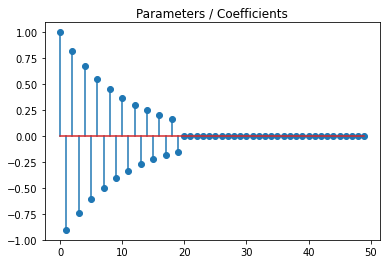

In [ ]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [ ]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [ ]:
A_LINREG, b_LINREG = simu_linreg(coefs)
A_LOGREG, b_LOGREG = simu_logreg(coefs)

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{\lambda\,R}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization: $\lambda\, R(z) = \frac{\lambda}{2} \|z\|_2^2$
- L1 penalization: $\lambda\, R(z) = \lambda\|z|\|_1$

where $\lambda \geq 0$ is a regularization parameter.

In [ ]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    z = np.sign(x) * np.maximum(0, np.abs(x) - lmbd)
    return z

def L1_pen(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd * np.sum(np.abs(x))

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""
    z = x / (1 + lmbd)
    return z

def L2_pen(x, lmbd):
    """Value of the L2 penalization at x"""
    return lmbd * np.sum(np.square(x)) / 2

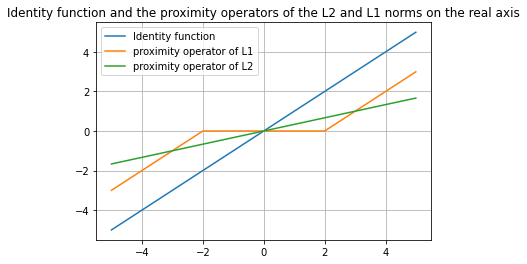

In [ ]:
lmbd = 2
X = np.arange(-5, 5, 0.01)

for (y, label) in [(X, 'Identity function'), (prox_L1(X, lmbd), 'proximity operator of L1'), (prox_L2(X, lmbd), 'proximity operator of L2')] :
  plt.plot(X, y, label=label)

plt.grid()
plt.legend()
plt.title('Identity function and the proximity operators of the L2 and L1 norms on the real axis')
plt.show()

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This signific

(-2.0, 2.0)

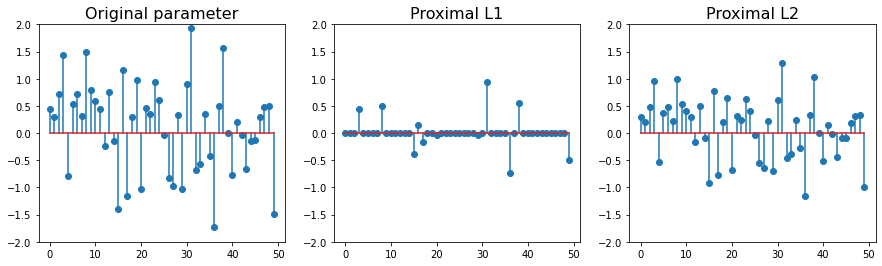

In [ ]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

To observe the effect of proximity operators on coefficients we have applied `prox_L1` and `prox_L2` to a random vector of 50 random coefficients. 

As we can see, the `prox_L1` returns a sparse vector keeping only the coefficients of x having the greatest values and zeroing the others. Actually, it keeps only the coefficient that have an absolute value bigger than lambda thanks to the maximum and substract lambda to them.

Differently, the `prox_L2` returns a vector very similar to x but with a smaller amplitude because all the coefficients have been divided by $1+\lambda$.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ is prox friendly.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A^\top = [a_1,\ldots, a_n] \in \mathbb{R}^{d \times n}$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient $\nabla f$

In [ ]:
def f_linreg(x):
    """Least squares loss"""
    return np.dot((b_LINREG - np.dot(A_LINREG, x)).T, b_LINREG - np.dot(A_LINREG, x)) / (2 * n_samples)

def grad_f_linreg(x):
    """Least squares gradient"""
    return np.dot(A_LINREG.T, np.dot(A_LINREG, x) - b_LINREG) / n_samples

def f_logreg(x):
    """Logistic loss"""
    return np.sum(np.log(1 + np.exp(- b_LOGREG * A_LOGREG.dot(x)))) / n_samples

def grad_f_logreg(x):
    """Logistic gradient"""
    return - np.sum(b_LOGREG * A_LOGREG.T / (1 + np.exp(b_LOGREG * np.dot(A_LOGREG, x))), axis=1) / n_samples

In [ ]:
from scipy.optimize import check_grad 
print(check_grad(f_linreg, grad_f_linreg, np.ones(50)))
print(check_grad(f_logreg, grad_f_logreg, np.ones(50)))

[1.73 2.94 2.11 3.2  3.22 3.32 2.57 2.84 2.52 2.75 2.64 3.87 2.98 3.04
 3.13 3.51 2.88 2.26 2.7  3.46 3.32 2.85 3.03 2.66 2.84 3.25 3.47 3.43
 3.1  2.99 3.01 3.24 3.22 3.   2.73 3.15 3.48 3.15 3.14 2.48 2.57 3.06
 3.52 3.44 3.73 2.95 2.71 2.65 2.47 1.91]
6.9871284836678834e-06
3.18628263771161e-07


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_{\lambda R}$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

In [ ]:
# Calculate the smoothness constant for least squares loss
def smoothness_const_linreg(A):
    """Lipschitz constant for least squares loss"""    
    return (np.linalg.norm(A, ord=2) ** 2) / n_samples

# Calculate the smoothness constant for logistic loss    
def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss"""    
    return (np.linalg.norm(A, ord=2) ** 2) / (4 * n_samples)
        
def PGD(A, x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm"""
    x = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        x = prox_R(x - grad_f(x) / step, lmbd / step)

        ##############
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [ ]:
""" Also called FISTA in the lecture slides """
def APGD(A, x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
 
        ### Code the update of the iterates x and z
        x_new = prox_R(z - grad_f(z) / step, lmbd / step)
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        z_new = x_new + (x_new - x) * (t - 1) / t_new
        x, z, t = x_new, z_new, t_new
 
        #################
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [ ]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 100
lmbd = 1e-2

In [ ]:
step_LINREG = smoothness_const_linreg(A_LINREG)
step_LOGREG = smoothness_const_loreg(A_LOGREG)

minimizer_LINREG_L1, _, _ = APGD(A_LINREG, x0, f_linreg, grad_f_linreg, L1_pen, prox_L1, step_LINREG, lmbd=lmbd, n_iter=2000, verbose=False)
minimizer_LINREG_L2, _, _ = APGD(A_LINREG, x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, step_LINREG, lmbd=lmbd, n_iter=2000, verbose=False)
minimizer_LOGREG_L1, _, _ = APGD(A_LOGREG, x0, f_logreg, grad_f_logreg, L1_pen, prox_L1, step_LOGREG, lmbd=lmbd, n_iter=2000, verbose=False)
minimizer_LOGREG_L2, _, _ = APGD(A_LOGREG, x0, f_logreg, grad_f_logreg, L2_pen, prox_L2, step_LOGREG, lmbd=lmbd, n_iter=2000, verbose=False)


In [ ]:
x_PGD_LINREG_L1, objectives_PGD_LINREG_L1, errors_PGD_LINREG_L1 = PGD(A_LINREG, x0, f_linreg, grad_f_linreg, L1_pen, prox_L1, step_LINREG, lmbd=lmbd, n_iter=n_iter, x_true=minimizer_LINREG_L1, verbose=False)

In [ ]:
x_PGD_LINREG_L2, objectives_PGD_LINREG_L2, errors_PGD_LINREG_L2 = PGD(A_LINREG, x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, step_LINREG, lmbd=lmbd, n_iter=n_iter, x_true=minimizer_LINREG_L2, verbose=False)

In [ ]:
x_PGD_LOGREG_L1, objectives_PGD_LOGREG_L1, errors_PGD_LOGREG_L1 = PGD(A_LOGREG, x0, f_logreg, grad_f_logreg, L1_pen, prox_L1, step_LOGREG, lmbd=lmbd, n_iter=n_iter, x_true=minimizer_LOGREG_L1, verbose=False)

In [ ]:
x_PGD_LOGREG_L2, objectives_PGD_LOGREG_L2, errors_PGD_LOGREG_L2 = PGD(A_LOGREG, x0, f_logreg, grad_f_logreg, L2_pen, prox_L2, step_LOGREG, lmbd=lmbd, n_iter=n_iter, x_true=minimizer_LOGREG_L2, verbose=False)

In [ ]:
x_APGD_LINREG_L1, objectives_APGD_LINREG_L1, errors_APGD_LINREG_L1 = APGD(A_LINREG, x0, f_linreg, grad_f_linreg, L1_pen, prox_L1, step_LINREG, lmbd=lmbd, n_iter=n_iter, x_true=minimizer_LINREG_L1, verbose=False)

In [ ]:
x_APGD_LINREG_L2, objectives_APGD_LINREG_L2, errors_APGD_LINREG_L2 = APGD(A_LINREG, x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, step_LINREG, lmbd=lmbd, n_iter=n_iter, x_true=minimizer_LINREG_L2, verbose=False)

In [ ]:
x_APGD_LOGREG_L1, objectives_APGD_LOGREG_L1, errors_APGD_LOGREG_L1 = APGD(A_LOGREG, x0, f_logreg, grad_f_logreg, L1_pen, prox_L1, step_LOGREG, lmbd=lmbd, n_iter=n_iter, x_true=minimizer_LOGREG_L1, verbose=False)

In [ ]:
x_APGD_LOGREG_L2, objectives_APGD_LOGREG_L2, errors_APGD_LOGREG_L2 = APGD(A_LOGREG, x0, f_logreg, grad_f_logreg, L2_pen, prox_L2, step_LOGREG, lmbd=lmbd, n_iter=n_iter, x_true=minimizer_LOGREG_L2, verbose=False)

Text(0.5, 1.0, 'Error PGD/APGD, LOGREG L2')

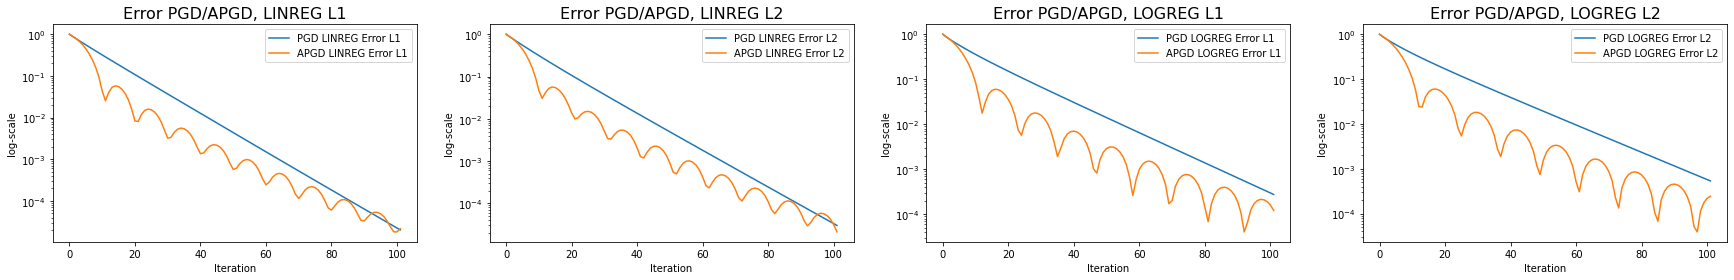

In [ ]:
plt.figure(figsize=(30.0, 4.0))

plt.subplot(1, 4, 1)
x_axis = [i for i in range(n_iter+2)]
plt.semilogy(x_axis, errors_PGD_LINREG_L1)
plt.semilogy(x_axis, errors_APGD_LINREG_L1)
plt.legend(["PGD LINREG Error L1", "APGD LINREG Error L1"])
plt.xlabel('Iteration')
plt.ylabel('log-scale')
plt.title("Error PGD/APGD, LINREG L1", fontsize=16)

plt.subplot(1, 4, 2)
plt.semilogy(x_axis, errors_PGD_LINREG_L2)
plt.semilogy(x_axis, errors_APGD_LINREG_L2)
plt.legend(["PGD LINREG Error L2", "APGD LINREG Error L2"])
plt.xlabel('Iteration')
plt.ylabel('log-scale')
plt.title("Error PGD/APGD, LINREG L2", fontsize=16)

plt.subplot(1, 4, 3)
plt.semilogy(x_axis, errors_PGD_LOGREG_L1)
plt.semilogy(x_axis, errors_APGD_LOGREG_L1)
plt.legend(["PGD LOGREG Error L1", "APGD LOGREG Error L1"])
plt.xlabel('Iteration')
plt.ylabel('log-scale')
plt.title("Error PGD/APGD, LOGREG L1", fontsize=16)

plt.subplot(1, 4, 4)
plt.semilogy(x_axis, errors_PGD_LOGREG_L2)
plt.semilogy(x_axis, errors_APGD_LOGREG_L2)
plt.legend(["PGD LOGREG Error L2", "APGD LOGREG Error L2"])
plt.xlabel('Iteration')
plt.ylabel('log-scale')
plt.title("Error PGD/APGD, LOGREG L2", fontsize=16)


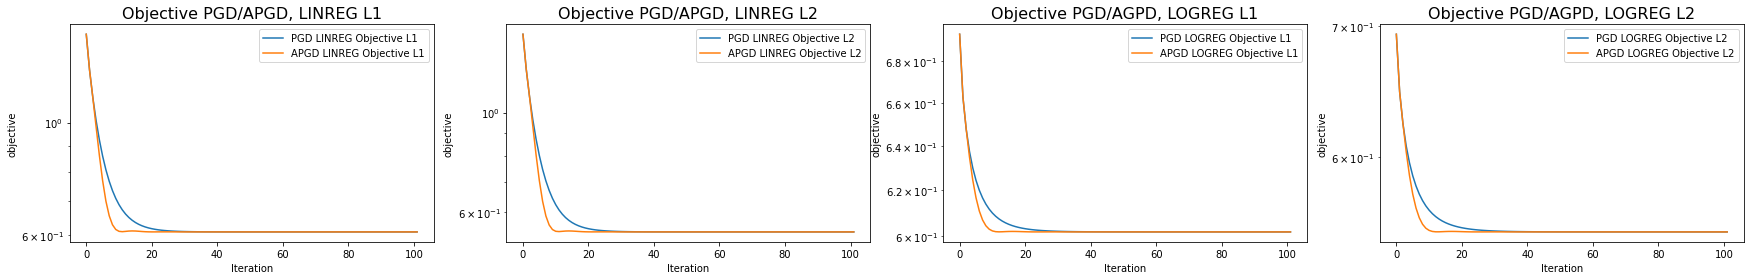

In [ ]:
plt.figure(figsize=(30.0, 4.0))

plt.subplot(1, 4, 1)
plt.semilogy(x_axis, objectives_PGD_LINREG_L1)
plt.semilogy(x_axis, objectives_APGD_LINREG_L1)
plt.xlabel('Iteration')
plt.ylabel('objective')
plt.title("Objective PGD/APGD, LINREG L1", fontsize=16)
plt.legend(["PGD LINREG Objective L1", "APGD LINREG Objective L1"])

plt.subplot(1, 4, 2)
plt.semilogy(x_axis, objectives_PGD_LINREG_L2)
plt.semilogy(x_axis, objectives_APGD_LINREG_L2)
plt.xlabel('Iteration')
plt.ylabel('objective')
plt.title("Objective PGD/APGD, LINREG L2", fontsize=16)
plt.legend(["PGD LINREG Objective L2", "APGD LINREG Objective L2"])


plt.subplot(1, 4, 3)
plt.semilogy(x_axis, objectives_PGD_LOGREG_L1)
plt.semilogy(x_axis, objectives_APGD_LOGREG_L1)
plt.xlabel('Iteration')
plt.ylabel('objective')
plt.title("Objective PGD/AGPD, LOGREG L1", fontsize=16)
plt.legend(["PGD LOGREG Objective L1", "APGD LOGREG Objective L1"])


plt.subplot(1, 4, 4)
plt.semilogy(x_axis, objectives_PGD_LOGREG_L2)
plt.semilogy(x_axis, objectives_APGD_LOGREG_L2)
plt.xlabel('Iteration')
plt.ylabel('objective')
plt.title("Objective PGD/AGPD, LOGREG L2", fontsize=16)
plt.legend(["PGD LOGREG Objective L2", "APGD LOGREG Objective L2"])


### We compare the convergences of PGD and APGD, in terms of distance to the minimum and distance to the minimizer :

As you can see on the previous graphs, PGD and APGD have a quite different behavior in the way they reach their goal. 

Concerning the distance to the minimizer **(Errors graphs)** it seems that it makes some bumps for the APGD algorithm. While this distance decreases at each step for the PGD algorithm it is not the case for the APGD algorithm which looks more unstable. However, this distance overall decreases for both algorithms and faster for the APGD algorithm.

Concerning the distance to the minimum **(Objectives graphs)**, we observe a difference in speed between the two algorithms. While the PGD algorithm needs around 30 iterations to reach its plateau, it is only 15 for the APGD algorithm. So even if the APGD algorithm is more unstable concerning the distance between its solution and the minimizer, the objective function decreases really faster than with the PGD algorithm.

### We compare the solution you obtain with ista and fista with the true parameter `coefs` of the model :

In [ ]:
sol_ISTA_LINREG_L1, _, _ = PGD(A_LINREG, x0, f_linreg, grad_f_linreg, L1_pen, prox_L1, step_LINREG, lmbd=lmbd, n_iter=100, verbose=False)
sol_ISTA_LINREG_L2, _, _ = PGD(A_LINREG, x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, step_LINREG, lmbd=lmbd, n_iter=100, verbose=False)
sol_ISTA_LOGREG_L1, _, _ = PGD(A_LOGREG, x0, f_logreg, grad_f_logreg, L1_pen, prox_L1, step_LOGREG, lmbd=lmbd, n_iter=100, verbose=False)
sol_ISTA_LOGREG_L2, _, _ = PGD(A_LOGREG, x0, f_logreg, grad_f_logreg, L2_pen, prox_L2, step_LOGREG, lmbd=lmbd, n_iter=100, verbose=False)

sol_FISTA_LINREG_L1, _, _ = APGD(A_LINREG, x0, f_linreg, grad_f_linreg, L1_pen, prox_L1, step_LINREG, lmbd=lmbd, n_iter=100, verbose=False)
sol_FISTA_LINREG_L2, _, _ = APGD(A_LINREG, x0, f_linreg, grad_f_linreg, L2_pen, prox_L2, step_LINREG, lmbd=lmbd, n_iter=100, verbose=False)
sol_FISTA_LOGREG_L1, _, _ = APGD(A_LOGREG, x0, f_logreg, grad_f_logreg, L1_pen, prox_L1, step_LOGREG, lmbd=lmbd, n_iter=100, verbose=False)
sol_FISTA_LOGREG_L2, _, _ = APGD(A_LOGREG, x0, f_logreg, grad_f_logreg, L2_pen, prox_L2, step_LOGREG, lmbd=lmbd, n_iter=100, verbose=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of in

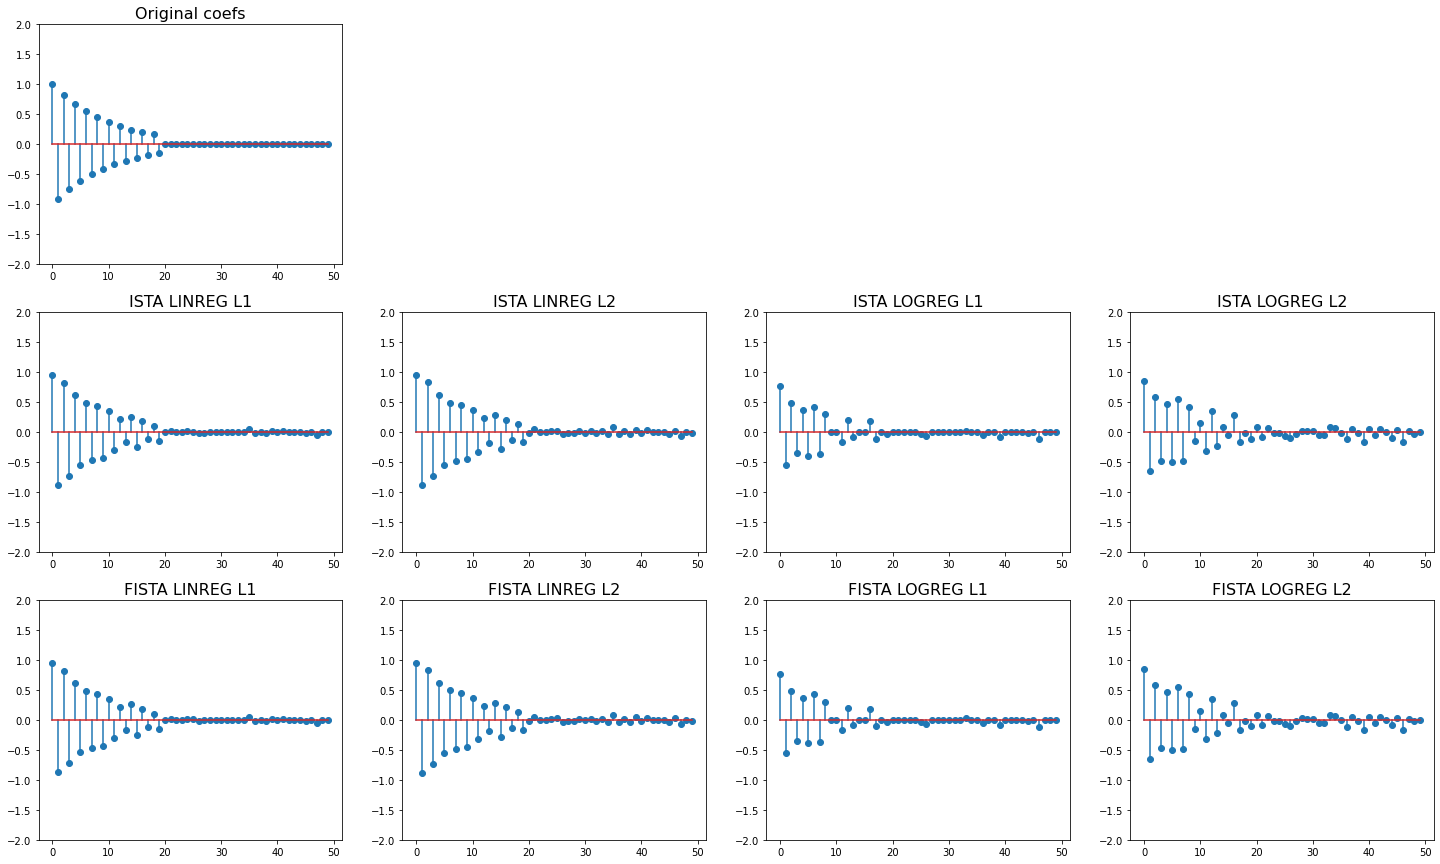

In [ ]:
plt.figure(figsize=(25.0, 15.0))
plt.subplot(3, 4, 1)
plt.stem(coefs)
plt.title("Original coefs", fontsize=16)
plt.ylim([-2, 2])

labels = ["ISTA LINREG L1", "ISTA LINREG L2", "ISTA LOGREG L1", "ISTA LOGREG L2",
         "FISTA LINREG L1", "FISTA LINREG L2", "FISTA LOGREG L1", "FISTA LOGREG L2"]
for i, sol in enumerate([sol_ISTA_LINREG_L1, sol_ISTA_LINREG_L2, sol_ISTA_LOGREG_L1,
                         sol_ISTA_LOGREG_L2, sol_FISTA_LINREG_L1, sol_FISTA_LINREG_L2,
                         sol_FISTA_LOGREG_L1, sol_FISTA_LOGREG_L2]) :
    plt.subplot(3, 4, i+5)
    plt.stem(sol)
    plt.title(labels[i], fontsize=16)
    plt.ylim([-2, 2])

We have plot the result of the ISTA and FISTA for all kind of regressions and penalizations for 100 iterations. I seems that the solutions are the same for ISTA and FISTA which was quite expected seeing their behavior. The difference between these two algorithms lies more in the way they reach their solutions than in the solutions theirself.

### We study the influence of the correlation of the features on the performance of the optimization algorithms :

With a parameter `corr=0.2` :

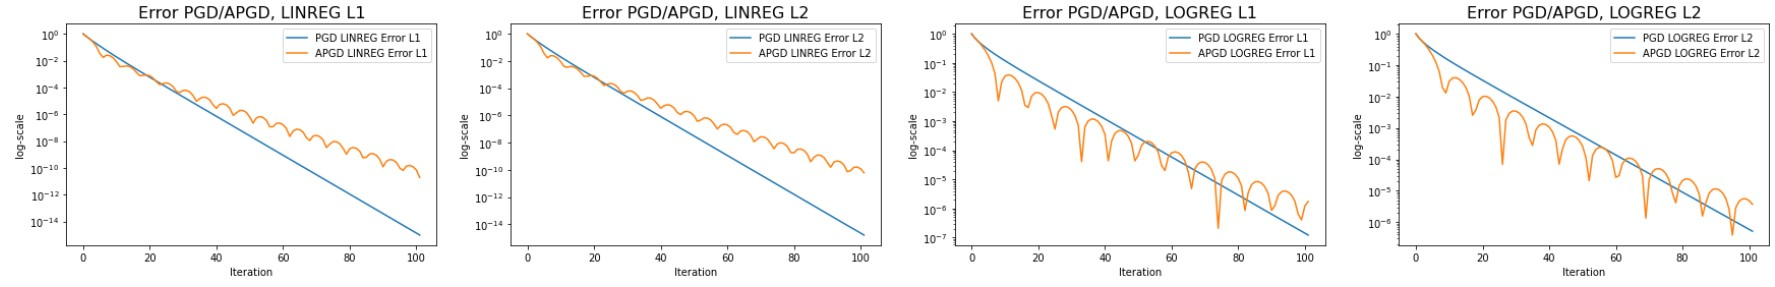

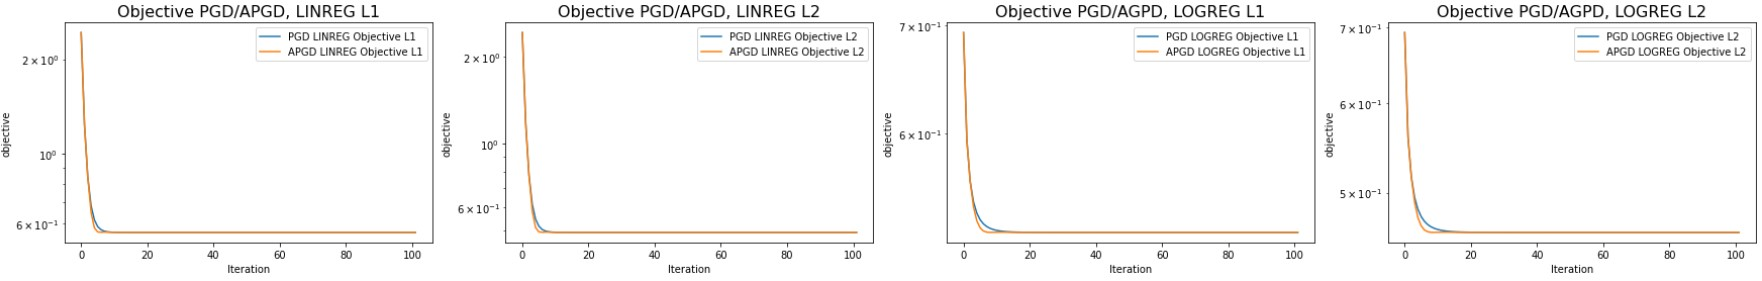

With a parameter `corr=0.8` :

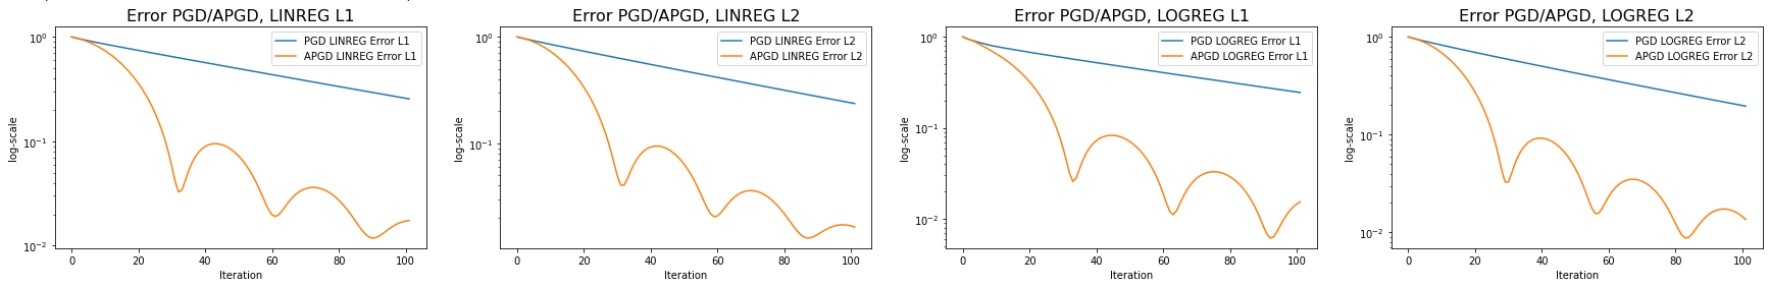

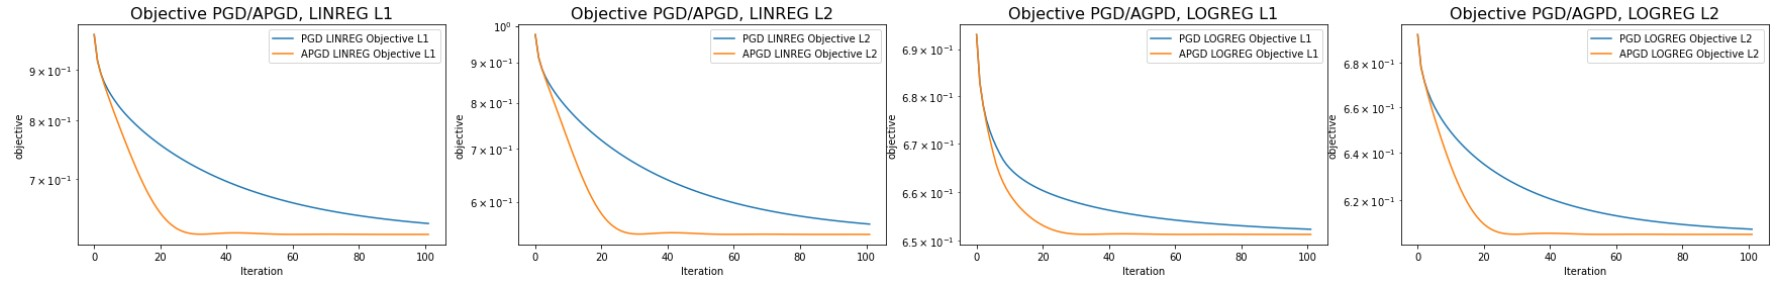

We have plot the performance on our algorithms in terms of distance to the minimizer and distance to the minimum for 100 iterations for a correlation parameter equal to $0.2$ and then $0.8$.

We observe more but smaller bumps for the APGD algorithm when the correlation is small and fewer but bigger bumps when the correlation is higher, so APGD seems far more stable when the correlation is low.

It seems that our algorithms are far better when the correlation is small. Indeed, we need around 5-10 iterations to reach the minimum for `corr=0.2` while we need 30 iterations to reach it with `corr=0.8` for APGD and around 100 for PGD. The type of regression and penalization don't have a very significative impact on the performance.

### We study the influence of the level of L2 penalization on the performance of the optimization algorithms :

With a parameter `lambda=1` :

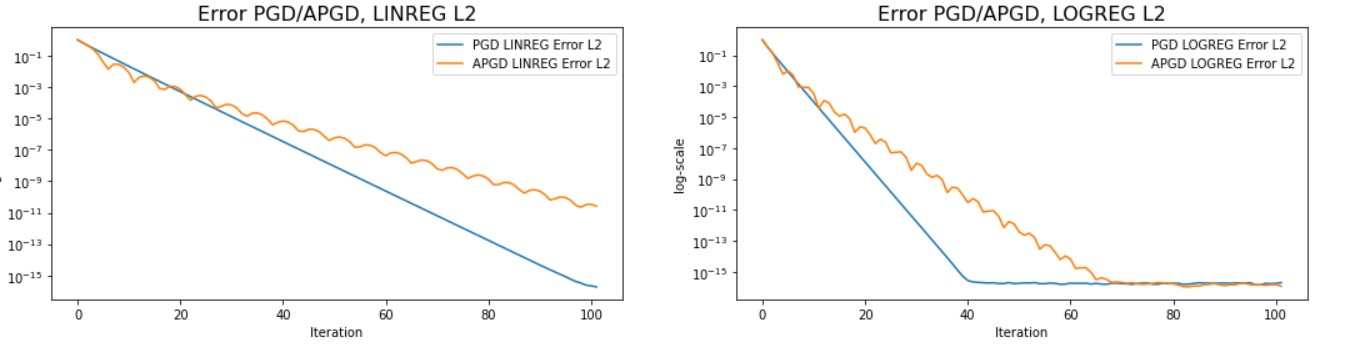

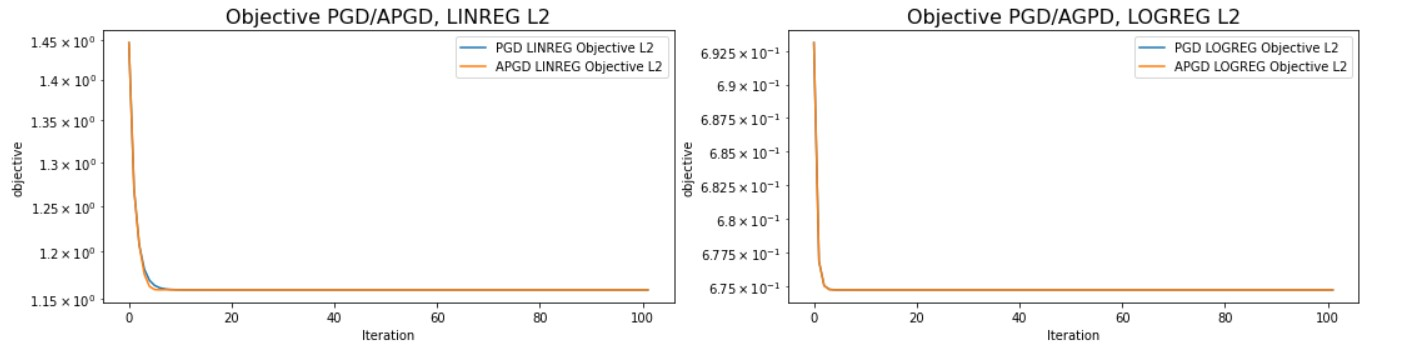

With a parameter `lambda=0.1` :

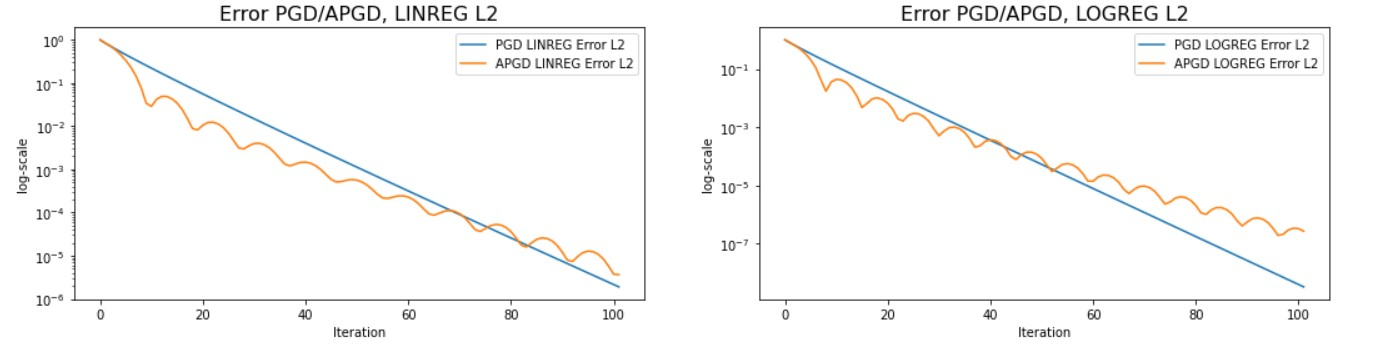

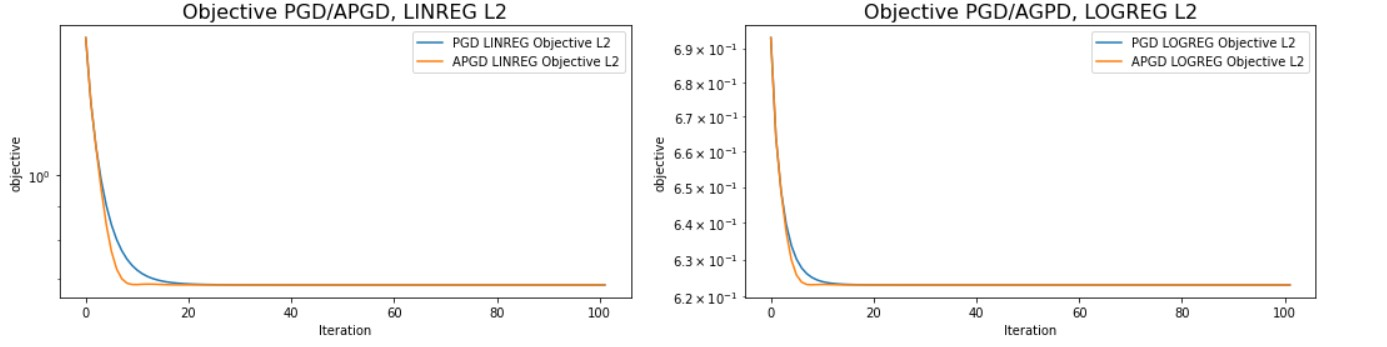

With a parameter `lambda=0` :

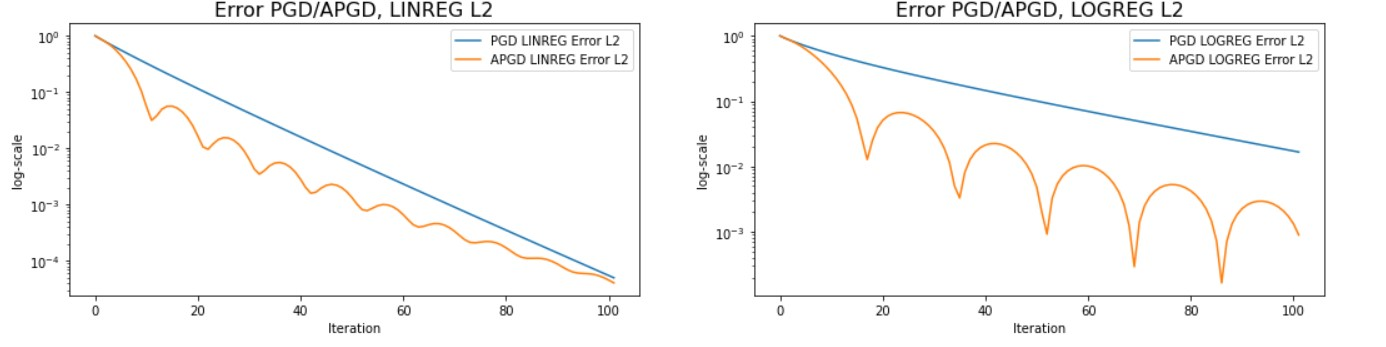

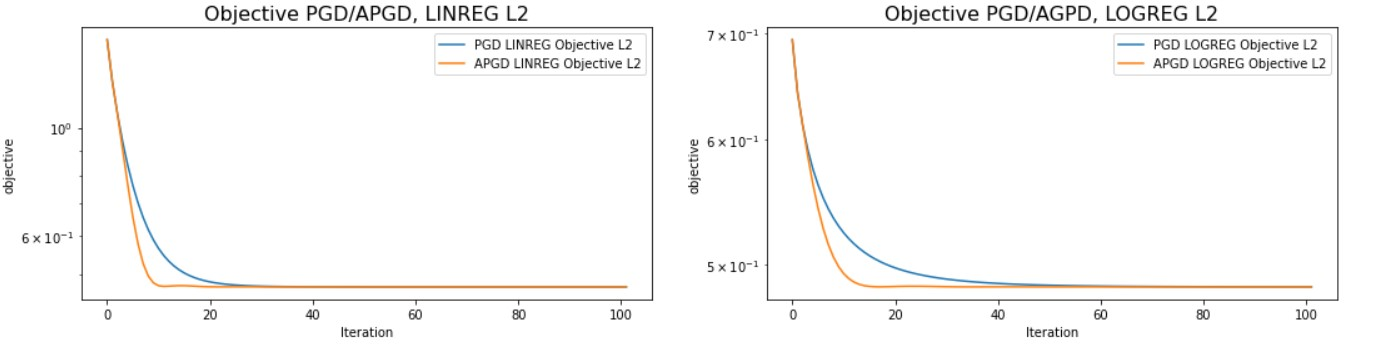

We have plot the performance our algorithms for both types of regression with an L2 penalization for three values of  the `lambda` parameter : $0$, $0.1$ and $1$. It seems that the higher lambda is the bigger the distance with the minimum is, especially for the linear regression. However, with a bigger lambda our algorithms are way faster than with a small value.

It is due to the fact that for a high level of penalization our algorithm will try to find a predictor that is less complex. As a result, it is easier to train it (which explains the better speed) but because it is simpler it has worse results (which explains the bigger error). 

### We compare the performance of the optimization algorithms for L2 and L1 penalizations :

We know that adding a penalizations ensure the model to be less confronted to overfitting (low bias, high variance). So by adding a penalization, we simply add some bias. 

But now, let's compare L1 et L2 penalization. 

From the graphs above, L2 penalization gives more precise values for the final output (the objective function is overall lower).
We remember from the beginning that L1 penalization tends to shrink a lot of coefficients and add "too much bias" when L2 shrinks less.

In addition, looking at the stems, L1 penalization seems to be pretty good when we have a sparse vector as it only keeps the one with a significant absolute value. On the other hand, L2 is good when we want a good precision for the features having a samll value because it doesn't shrink them to zero.